In [35]:
# Essentials
import numpy as np
import pandas as pd
import datetime
import random
import time
import ssl
import math

# Plots
import seaborn as sns
import matplotlib.pyplot as plt

# OpenML
import openml
# Stats
from scipy import stats
from scipy.stats import skew, norm, boxcox_normmax, randint, uniform
from scipy.special import boxcox1p


In [36]:
!pip install openml
!pip install optuna

In [37]:
df = pd.read_csv('https://www.openml.org/data/get_csv/31/dataset_31_credit-g.csv')

In [38]:
df.head()

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,...,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class
0,'<0',6,'critical/other existing credit',radio/tv,1169,'no known savings','>=7',4,'male single',none,...,'real estate',67,none,own,2,skilled,1,yes,yes,good
1,'0<=X<200',48,'existing paid',radio/tv,5951,'<100','1<=X<4',2,'female div/dep/mar',none,...,'real estate',22,none,own,1,skilled,1,none,yes,bad
2,'no checking',12,'critical/other existing credit',education,2096,'<100','4<=X<7',2,'male single',none,...,'real estate',49,none,own,1,'unskilled resident',2,none,yes,good
3,'<0',42,'existing paid',furniture/equipment,7882,'<100','4<=X<7',2,'male single',guarantor,...,'life insurance',45,none,'for free',1,skilled,2,none,yes,good
4,'<0',24,'delayed previously','new car',4870,'<100','1<=X<4',3,'male single',none,...,'no known property',53,none,'for free',2,skilled,2,none,yes,bad


#  This dataset has 1000 rows and 21 columns

In [39]:
df.shape

(1000, 21)

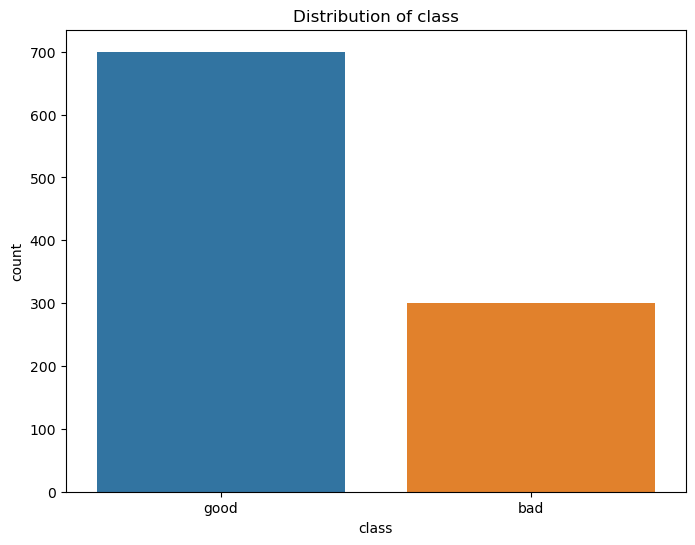

In [40]:
# Visualize the distribution of the target column 'class'
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='class')
plt.title('Distribution of class')
plt.show()

# Bar Chart of Age

Text(0, 0.5, 'Population')

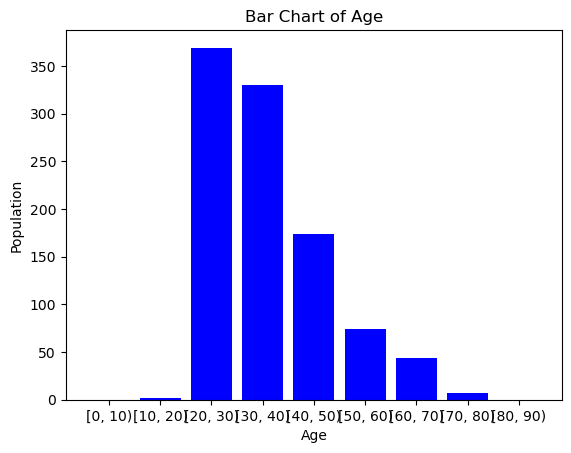

In [41]:
x = df['age']
age_groups = pd.cut(x, bins=range(0, 100, 10), right=False)
age_counts = age_groups.value_counts().sort_index()
plt.bar(age_counts.index.astype(str), age_counts.values, color='blue')
plt.title('Bar Chart of Age')
plt.xlabel('Age')
plt.ylabel('Population')

The distribution of credit amounts shows that the majority of credit limits are concentrated in lower ranges, but there are also some exceptions with higher credit limits.
The distribution of ages indicates that most customers fall within the age range of 20 to 40 years old.

## Default rates across different age segments.

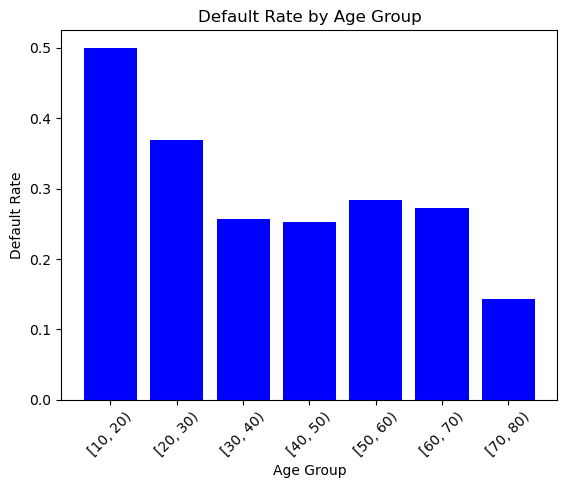

In [42]:
# 1. Create a new column for age groups
df['class_numeric'] = df['class'].map({'good': 0, 'bad': 1})
df['age_group'] = pd.cut(df['age'], bins=range(0, 100, 10), right=False)
# 2. Calculate the default rate for each age group
default_rate = df.groupby('age_group')['class_numeric'].mean()

# 3. Plot the default rate for each age group
plt.bar(default_rate.index.astype(str), default_rate.values, color='blue')
plt.title('Default Rate by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Default Rate')
plt.xticks(rotation=45)
plt.show()


It can be observed that the default rate is highest among individuals aged 20-30, while the age group of 10-20 can be considered negligible.

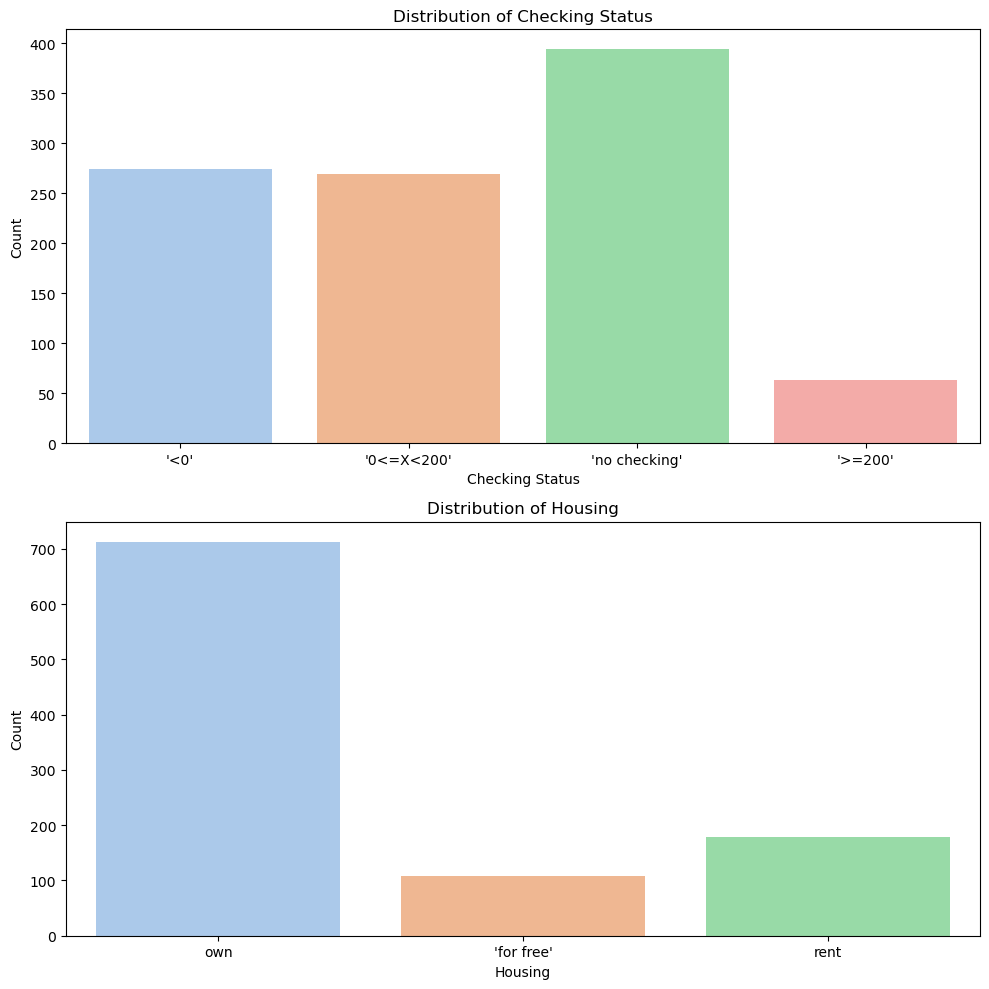

In [43]:
# Visualize the distribution of 'checking_status' and 'housing'
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))

# Countplot for checking_status
sns.countplot(data=df, x='checking_status', ax=axes[0], palette='pastel')
axes[0].set_title('Distribution of Checking Status')
axes[0].set_xlabel('Checking Status')
axes[0].set_ylabel('Count')

# Countplot for housing
sns.countplot(data=df, x='housing', ax=axes[1], palette='pastel')
axes[1].set_title('Distribution of Housing')
axes[1].set_xlabel('Housing')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()


In the distribution of Checking Status, most individuals have no checking, followed by accounts with less than 100.

Regarding Housing situation, the majority of people own their homes, followed by those who rent, and lastly, individuals with free housing.

# Loan Purpose Distribution

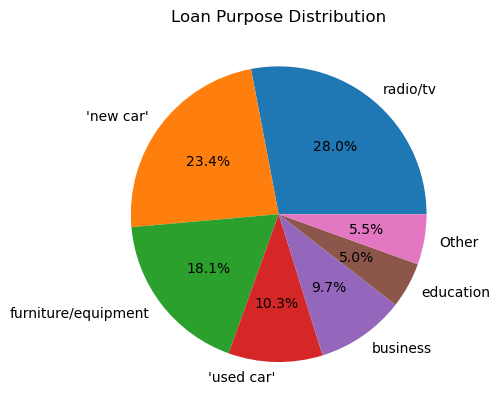

In [44]:
# Assuming df is your dataframe
purpose_freq = df['purpose'].value_counts()
total = len(df)
purpose_percentage = (purpose_freq / total) * 100

# Identify purposes less than 5% and combine them as 'Other'
mask = purpose_percentage < 5
other_count = purpose_freq[mask].sum()
purpose_freq = purpose_freq[~mask]
purpose_freq['Other'] = other_count

plt.pie(purpose_freq, labels=purpose_freq.index, autopct='%1.1f%%')
plt.title('Loan Purpose Distribution')
plt.show()


# Histogram of Credit Amount

Text(0.5, 1.0, 'Histogram of Credit Amount')

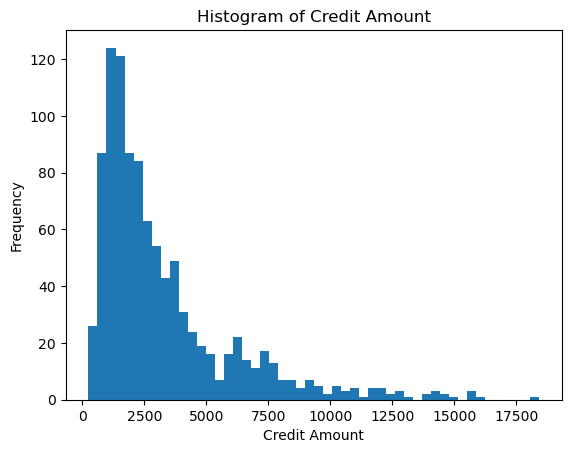

In [45]:
plt.hist(df['credit_amount'], bins=50)
plt.xlabel('Credit Amount')
plt.ylabel('Frequency')
plt.title('Histogram of Credit Amount')

# Line chart of age versus credit amount.

Text(0, 0.5, 'Mean Credit Amount')

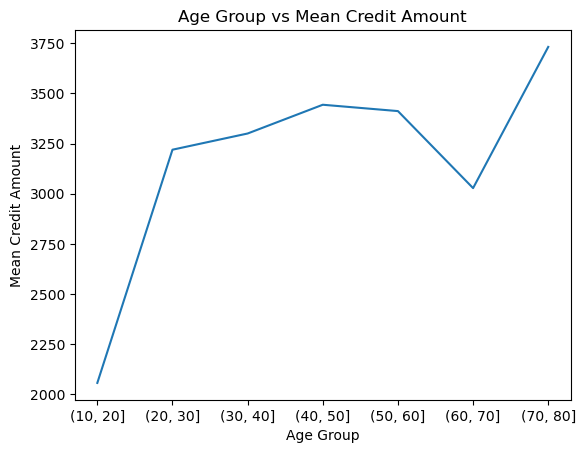

In [46]:
df['age_group'] = pd.cut(df['age'], bins=range(0, 101, 10))
credit_amount_by_age_group = df.groupby('age_group')['credit_amount'].mean()
plt.plot(credit_amount_by_age_group.index.astype(str), credit_amount_by_age_group.values)
plt.title('Age Group vs Mean Credit Amount')
plt.xlabel('Age Group')
plt.ylabel('Mean Credit Amount')

# Draw a heatmap of correlation coefficients.

/var/folders/39/cjs27lrd0xx4r9kd_4jf9chr0000gn/T/ipykernel_90484/3199072236.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


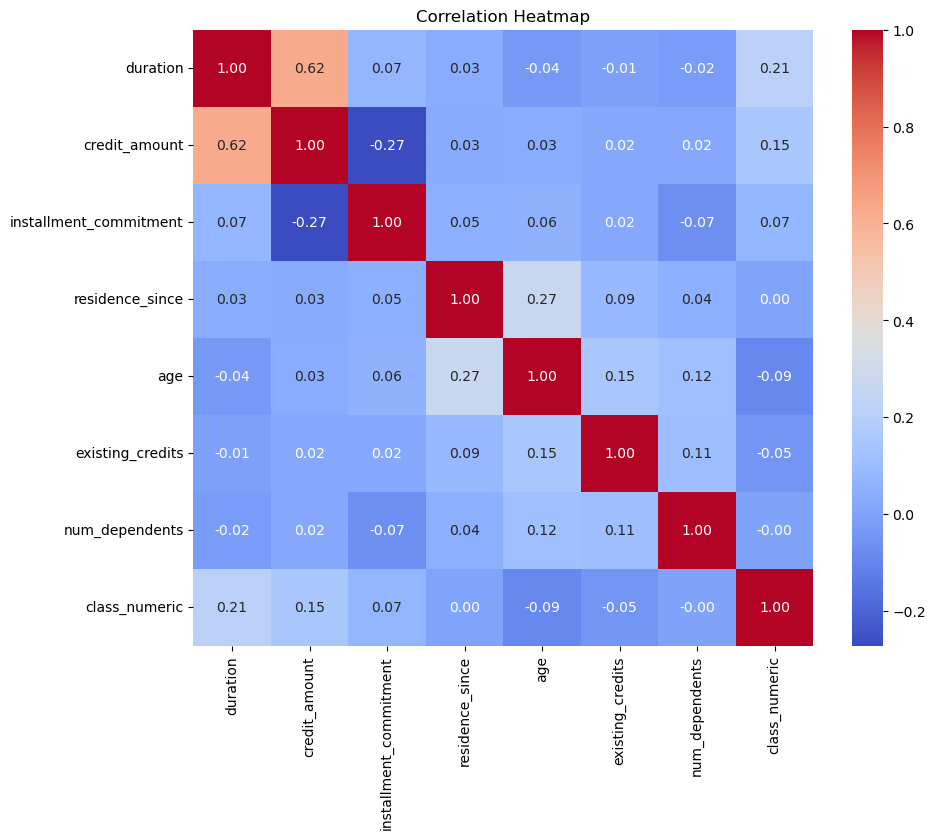

In [47]:
# Calculate correlation coefficients.
correlation_matrix = df.corr()

# Draw a heatmap
plt.figure(figsize=(10, 8))  
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')  
plt.show()
